Carrying on from the previous Supervised SA notebook, this one concerns classification modelling, hyperparameter tuning, and evaluation metrics.

### Imports & Setup

In [6]:
# Imports and Setup
import os
import re
import email
import random
import collections
import itertools
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from string import punctuation
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk import classify
from sklearn import metrics, preprocessing, feature_extraction, linear_model, naive_bayes, ensemble, pipeline, svm, model_selection, decomposition
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.datasets import make_classification
from sklearn import tree, datasets
from scipy import stats
from sklearn.decomposition import TruncatedSVD

# Ensure NLTK libraries up to date:
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')

# Tell TensorFlow to run all deep learning on GPU:
tf.config.set_soft_device_placement
tf.test.is_built_with_cuda()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Tell TensorFlow to run all deep learning on GPU:
tf.config.set_soft_device_placement
tf.test.is_built_with_cuda()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
# Feature extractor and vectorizer, to produce TF-IDF document matrix:
def feature_vectorizer(corpus):
    sa_stop_words = nltk.corpus.stopwords.words('english')
    ''' Create a list of exceptions, as these stopwords may change a sentence's sentiment if removed. '''
    sa_white_list = ['what', 'but', 'if', 'because', 'as', 'until', 'against', 'up', 'down', 'in', 'out',
                    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'why',
                    'how', 'all', 'any', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
                    'same', 'so', 'than', 'too', 'can', 'will', 'just', 'don', 'should']
    ''' Remove stop words except for those specified in the white list. '''
    sa_stop_words = [sw for sw in sa_stop_words if sw not in sa_white_list]
    ''' Instantiate the vectorizer. '''
    count_vectorizer = feature_extraction.text.CountVectorizer(
        lowercase = True,
        tokenizer = nltk.word_tokenize,
        min_df=2, # this means the term frequency must be 2 or higher.
        ngram_range=(1,2),
        stop_words=sa_stop_words
    )
    ''' Run the vectorizer on the body of text ('corpus'). '''
    processed_corpus = count_vectorizer.fit_transform(corpus)
    processed_corpus = feature_extraction.text.TfidfTransformer().fit_transform(processed_corpus)
    return processed_corpus

def data_integrity_check(df, title='', include_non_numeric=True):
    '''Check for nulls, duplicates, etc and perform basic EDA.'''
    results = []
    for col in df:
        result = {
            'Column': col,
            'Null Values': df[col].isnull().sum(),
            'Duplicate Values': df[col].duplicated().sum(),
            'Data Type': df[col].dtype
        }
        if include_non_numeric or df[col].dtype in ['int64', 'float64']:
            result['Unique Values'] = df[col].nunique()
            if df[col].dtype in ['int64', 'float64']:
                result['Mean'] = df[col].mean()
                result['Median'] = df[col].median()
                result['Mode'] = stats.mode(df[col])
                result['Range'] = df[col].max() - df[col].min()
                result['Skew'] = df[col].skew()
                result['Kurtosis'] = df[col].kurtosis()
        if df[col].dtype == 'object':  
            result['Min Text Length'] = df[col].str.len().min()
            result['Max Text Length'] = df[col].str.len().max()
            '''Calculate mean and median text lengths'''
            text_lengths = df[col].str.len()
            result['Mean Text Length'] = np.mean(text_lengths)
            result['Median Text Length'] = np.median(text_lengths)
        results.append(result)
    result_df = pd.DataFrame(results)
    result_df['Source'] = title
    return result_df

# Prints performance metrics for classifiers:
def print_classification_report(y_true, y_pred):
    '''Get a classification report for performance metric inspection.'''
    report = classification_report(y_true, y_pred)
    print(report)

## Classification:

In [9]:
# Import dataset from preprocessing outputs:
df_sa = pd.read_csv('lsa_train_output.csv')
print(df_sa.shape)

# Reimport training labels:
df_train = pd.read_csv('sa_train.csv')
print(df_train.shape)

(159571, 400)
(159571, 8)


Let's start with a simple multi-output logistic regression:

In [10]:
# Create train/test split:
X_training = df_sa
y = df_train[df_train.columns[2:]].values
X_train, X_test, y_train, y_test = train_test_split(X_training, y, test_size = 0.3, random_state=123)

# Define common hyperparameter settings for GridSearch:
param_grid_lr = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': [0.001, 0.01, 0.1, 0.25, 0.5],
    'estimator__class_weight': [None, 'balanced'],
}

# Instantiate classifiers:
base_LR_classifier = LogisticRegression(solver='liblinear')

# Wrap classifiers with MultiOutput:
multi_classifier_lr = MultiOutputClassifier(base_LR_classifier)

# Grid search for Logistic Regression
grid_search_lr = GridSearchCV(multi_classifier_lr, param_grid_lr, n_jobs=10) 
# n_jobs=10 to use 10 of my PC's 14 CPU cores for faster computation.
grid_search_lr.fit(X_train, y_train)
print('Best LR Model Performance: {:.4f}'.format(grid_search_lr.best_score_))
print('Best LR Model Parameters:', grid_search_lr.best_params_)

Best LR Model Performance: 0.9113
Best LR Model Parameters: {'estimator__C': 0.5, 'estimator__class_weight': None, 'estimator__penalty': 'l1'}


'Performance' refers to accuracy which is a single metric that represents the overall correctness of the classifier across all classes. While accuracy is easy to interpret and can provide a quick overview of performance, it may not be suitable for imbalanced datasets where the class distribution is skewed.

Time to run the classifiers based on those GridSearch outputs, see the code in the next block below.
I am rounding the probability predictions to a whole number to ensure consistency with binary format of training data (0 or 1 for comment features).
I am also printing a classification report so that we get a range of metrics other than just accuracy.

In [11]:
# 'Score' method in scikit-learn typically reports the accuracy of the model on the given dataset. 
# We need more metrics to better judge each model:

# Print classes with matching number for reference:
class_mapping = {
        0: 'Toxic',
        1: 'Severely Toxic',
        2: 'Obscene',
        3: 'Threat',
        4: 'Insult',
        5: 'Identity Hate'
        }

# Retrieve best parameters from GridSearch:
best_lr_params = grid_search_lr.best_params_

# Remove 'estimator__' prefix from the parameter names to prevent TypeError:
best_lr_params_cleaned = {key.replace('estimator__', ''): value for key, value in best_lr_params.items()}

# Instantiate LogisticRegression with best parameters:
best_lr_classifier = LogisticRegression(**best_lr_params_cleaned, solver='liblinear')

# Wrap LogisticRegression in MultiOutputClassifier:
best_multi_classifier_lr = MultiOutputClassifier(best_lr_classifier)

# Fit the classifier to the training data:
best_multi_classifier_lr.fit(X_train, y_train)

# How accurately can it predict reserved test data in the train dataset?
y_pred_lr = best_multi_classifier_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr, target_names=class_mapping.values()))

                precision    recall  f1-score   support

         Toxic       0.88      0.54      0.67      4478
Severely Toxic       0.51      0.19      0.28       476
       Obscene       0.90      0.59      0.71      2499
        Threat       0.00      0.00      0.00       139
        Insult       0.81      0.46      0.58      2321
 Identity Hate       0.56      0.08      0.14       426

     micro avg       0.86      0.49      0.62     10339
     macro avg       0.61      0.31      0.40     10339
  weighted avg       0.83      0.49      0.61     10339
   samples avg       0.05      0.04      0.04     10339



Let's interpret the performance metrics for the logistic regression classifier:

_Precision:_ measures the proportion of correctly predicted positive instances among all instances predicted as positive.
- For class 0 (Toxic), the precision is 0.88, indicating that among all instances predicted as toxic, 88% are correctly classified.
- For class 1 (Severely Toxic), the precision is 0.51, meaning that only 51% of instances predicted as severely toxic are actually classified correctly.
- For class 2 (Obscene), the precision is 0.90, indicating a high proportion of correctly predicted obscene instances.
- For class 3 (Threat), the precision is 0.00, suggesting that none of the instances predicted as threats are correctly classified.
- For class 4 (Insult), the precision is 0.81, indicating a relatively high proportion of correctly predicted insult instances.
- For class 5 (Identity Hate), the precision is 0.56, indicating 56% were classified accurately but with low recall indicating false positives.

_Recall:_ measures the proportion of correctly predicted positive instances among all actual positive instances.
- The recall values are generally low across all classes, indicating that the classifier misses a significant portion of actual positive instances.
- For class 0 (Toxic), the recall is 0.54, meaning that only 54% of actual toxic instances are correctly classified.
- For class 1 (Severely Toxic), the recall is 0.19, indicating that only 19% of actual severely toxic instances are correctly classified.
- For class 2 (Obscene), the recall is 0.59, suggesting that nearly half of the actual obscene instances are correctly classified.
- For class 3 (Threat), the recall is 0.00, indicating that none of the actual threat instances are correctly classified.
- For class 4 (Insult), the recall is 0.46, indicating that 46% of actual insult instances are correctly classified.
- For class 5 (Identity Hate), the recall is 0.08, suggesting that only a very small proportion of actual identity hate instances are correctly classified.

To quickly explain the other above metrics:

- Macro-average: This average calculates the metric independently for each class and then takes the unweighted mean of the metrics. It gives equal weight to each class, regardless of its size. Macro-average is useful when you want to ensure that the classifier performs well across all classes, regardless of their prevalence.

- Micro-average: This average aggregates the contributions of all classes to compute the average metric. It gives equal weight to each prediction, regardless of the class.
Micro-average is useful when you want to evaluate the overall performance of the classifier, taking into account the imbalance in class frequencies.

- Weighted average: This average calculates the metric for each class and then takes a weighted average based on the number of true instances for each class. It gives more weight to classes with more instances, making it suitable for imbalanced datasets. Weighted average is useful when you want to prioritize the performance of the majority classes while still considering the minority classes.

Given what we know about this dataset from the Preprocessing workbook, I will use Micro Average and Weighted Average to judge overall performance.

_Micro Average:_
- Precision (0.86): This indicates that, on average, 86% of the instances predicted as positive are indeed positive across all classes. It's a measure of the overall correctness of the positive predictions.
- Recall (0.49): This indicates that, on average, 49% of the actual positive instances are correctly identified by the classifier across all classes. It's a measure of the classifier's ability to capture positive instances.
- F1-score (0.62): This is the harmonic mean of precision and recall and provides a balanced measure of the classifier's performance. It takes into account both false positives and false negatives and is useful for assessing overall classifier performance.

_Weighted Average:_
- Precision (0.83): This indicates the average precision across all classes, with each class's contribution weighted by its support (the number of true instances). Classes with more instances have a greater impact on this metric.
- Recall (0.49): This indicates the average recall across all classes, with each class's contribution weighted by its support. It's a measure of the classifier's ability to capture positive instances, accounting for class imbalance.
- F1-score (0.61): This is the weighted average of F1-scores across all classes, with each class's contribution weighted by its support. It provides a balanced measure of the classifier's performance, considering both precision and recall while accounting for class imbalance.

In summary, the logistic regression classifier demonstrates strong precision but relatively low recall in predicting the multi-label classes of toxic comments, severely toxic comments, obscene content, threats, insults, and identity hate in the test section of the training dataset. While the classifier achieves high precision in identifying positive instances, indicating a low rate of false positives across classes, its recall is notably lower, suggesting that it misses a significant portion of actual positive instances. 

In [12]:
# Okay, how does this trained LogReg perform on the test_dataset now?

# Classification labels for test data:
df_test_labels = pd.read_csv('sa_test_labels.csv')

# Test data with text only:
df_test_data = pd.read_csv('lsa_test_output.csv')

# Ensure binary nature of test labels:
df_test_labels[df_test_labels == -1] = 1
for col in df_test_labels:
    unique_values = df_test_labels[col].unique()
print(f'Data check: ', unique_values)

Data check:  [1 0]


In [13]:
# Input data/feature split:
X_testing = df_test_data
y_true = df_test_labels[df_test_labels.columns[1:]]

# Run LR classifier on test dataset:
y_pred_lr = best_multi_classifier_lr.predict(X_testing)
print(classification_report(y_true, y_pred_lr, target_names=class_mapping.values()))

                precision    recall  f1-score   support

         Toxic       0.67      0.14      0.23     95276
Severely Toxic       0.64      0.00      0.00     89553
       Obscene       0.64      0.06      0.11     92877
        Threat       0.00      0.00      0.00     89397
        Insult       0.65      0.02      0.04     92613
 Identity Hate       0.48      0.00      0.00     89898

     micro avg       0.66      0.04      0.07    549614
     macro avg       0.51      0.04      0.06    549614
  weighted avg       0.52      0.04      0.07    549614
   samples avg       0.09      0.03      0.04    549614



The training dataset generally shows significantly higher precision, recall, and F1-scores compared to the testing dataset across all classes.

Class imbalance might be a concern, especially noticeable in the testing dataset where recall is quite low for most classes, indicating that the model struggles to correctly identify instances of these classes. This would make sense because a visual inspection of the dataset confirms that a majority of the sample comments are non-toxic.

There's a significant drop in performance metrics between the training and testing datasets, indicating potential overfitting of the model to the training data. The model seems to generalize poorly to unseen data, suggesting the need for further model refinement or data augmentation techniques to improve generalization performance.

In [14]:
# Let's get a look at a confusion matrix:
cm_lr = multilabel_confusion_matrix(y_true, y_pred_lr)

# Printing confusion matrices:
print("\nConfusion Matrix LogReg:")
for i, cm in enumerate(cm_lr):
    class_name = class_mapping[i]
    print(f"\nClass {class_name}:\n{cm}")


Confusion Matrix LogReg:

Class Toxic:
[[51278  6610]
 [82098 13178]]

Class Severely Toxic:
[[63593    18]
 [89521    32]]

Class Obscene:
[[57090  3197]
 [87240  5637]]

Class Threat:
[[63767     0]
 [89397     0]]

Class Insult:
[[59561   990]
 [90789  1824]]

Class Identity Hate:
[[63253    13]
 [89886    12]]


I've noticed that different resources report different conventions with the orientation of confusion matrices.

To help with understanding output: https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

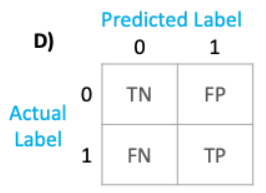

To interpret the confusion matrix output from its predictions of the test data:

Overall the logistic regression classifier demonstrates challenges in correctly classifying instances across all classes, with a notable imbalance between true negatives (TN), false negatives (FN), and true positives.

In [17]:
# Which convention does Sklearn follow?
y_true = [0, 1, 0, 1, 0, 1, 0, 0]
y_pred = [1, 1, 1, 0, 1, 0, 1, 0]
print(confusion_matrix(y_true, y_pred))

[[1 4]
 [2 1]]


We could spend lots of time tweaking this logistic regressor, but I was not expecting it to perform very well with this sort of task. Instead, it was just a starting point to consider other more advanced models.